In [1]:
#https://github.com/OceanParcels/GlobalMassBudget/blob/main/create_population_input.py

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [2]:
import pandas as pd
import urllib.request as urlr

import shapely as sh
import cartopy.io.shapereader as shpreader


input_data = '../../data/release/'
output_data = '../../data/release/generated_files/'

In [3]:
def distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1r = np.radians(lon1)
    lat1r = np.radians(lat1)
    lon2r = np.radians(lon2)
    lat2r = np.radians(lat2)

    #Implementing Haversine Formula:
    dlon = np.subtract(lon2r, lon1r)
    dlat = np.subtract(lat2r, lat1r)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
                          np.multiply(np.cos(lat1r),
                                      np.multiply(np.cos(lat2r),
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))

    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    r = 6371

    return c*r


def get_coords_from_polygon(shape):
    """
    Get a list of coordinate points on a Polygon
    (or MultiPolygon) shape
    """
    coords = []

    if isinstance(shape, sh.geometry.Polygon):
        coords.append(np.asarray(shape.exterior.coords[:-1]))
        for linearring in shape.interiors:
            coords.append(np.asarray(linearring.coords[:-1]))
    elif isinstance(shape, sh.geometry.MultiPolygon):
        #polygons = list(shape)
        for polygon in shape.geoms:
            coords.append(get_coords_from_polygon(polygon))
    coords = np.concatenate(coords)
    return coords

## GPW data
- if using WPP-adjusted: https://beta.sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11/data-download
- if using non-WPP-adjusted: https://beta.sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev11/data-download

select 'All Years Combined' > 'NetCDF' > '2.5 Minute (approx. 5km)'

In [4]:
# Load GPW Data, and set NaNs to zeros (i.e. zero population density in the ocean)
gpw = xr.open_dataset(input_data+'GPWv4/gpw-v4-population-density-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_rev11_2pt5_min.nc')
gpw = gpw.fillna(0.)

In [5]:
# Load in coast mask
data_mask_coast = xr.open_dataset('../../data/output_data/masks/mask_coast_NEMO0083.nc')
coords = xr.open_dataset('../../data/input_data/MOi/domain_ORCA0083-N006/coordinates.nc', decode_cf=False)
mask_coast = data_mask_coast['mask_coast'].values

#lons = data_mask_coast['lon']
#lats = data_mask_coast['lat']

lats_coast = data_mask_coast['lat'].data[np.where(data_mask_coast['mask_coast'])]
lons_coast = data_mask_coast['lon'].data[np.where(data_mask_coast['mask_coast'])]

# Compute the area of each grid cell
cell_areas = coords['e1t'][0] * coords['e2t'][0]/10e6 # in km**2
coastal_cell_areas = cell_areas.data[np.where(data_mask_coast['mask_coast'])]


In [6]:
# Maximum distance between a coastline point and a coastal grid cell
distance_threshhold = 50 #km

In [7]:
# Load Natural Earth dataset and plot country boundaries
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')

## Assign coastal grid cells to a country and give it a (2020 year) population density (maximum of population density values in a 50km radius).

In [10]:
reader = shpreader.Reader(shpfilename)
countries = reader.records()
continent = []
region_un = []
subregion = []
region_wb = []

#coastal_density_df = pd.DataFrame(columns = ['Continent', 'Region', 'Subregion', 'Country', 'Longitude', 'Latitude', 'PopulationDensity'])
coastal_density_list = []
for country in countries:
    # Get country information
    continent = country.attributes['CONTINENT']
    region_un = country.attributes['REGION_UN']
    subregion = country.attributes['SUBREGION']
    country_name = country.attributes['NAME_LONG']

    country_coords = get_coords_from_polygon(country.geometry)
    country_lons, country_lats = country_coords[:,0], country_coords[:,1] #= country.geometry.exterior.coords.xy

    # Assign each point a population density
    #population_densities = [] # Gives the pop. density for all country points
    #for i in range(len(country_lons)):
    #    coastal_point = [country_lons[i], country_lats[i]]
    #    # Raster = 4 is the 2020 data, nearest neighbour find pop.density
    #    population_density = np.float32(gpw['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].sel(longitude=coastal_point[0], latitude=coastal_point[1], raster=4, method='nearest').values)
    #    population_densities.append(population_density)


    # Loop through country points to find coastal points within [specified] km
    #all_coastal_indices_popdensity = []
    all_coastal_indices = []
    for i in range(len(country_lons)):
        distances = distance(np.repeat(country_lons[i], len(lons_coast)), np.repeat(country_lats[i], len(lats_coast)), lons_coast, lats_coast)
        coastal_indices = np.where(distances<=distance_threshhold)[0] # Coastal indices are those that are within the thresshold distance
        all_coastal_indices.append(coastal_indices)
        #all_coastal_indices_popdensity.append(np.array([coastal_indices, np.repeat(population_densities[i], len(coastal_indices))]).T) # Get coastal index and save the population density for this too
    
    #Concat into one big list
    #all_coastal_indices_popdensity = np.vstack(all_coastal_indices_popdensity)
    all_coastal_indices = np.hstack(all_coastal_indices)
    # Sort by first column then second column backwards (so largest number is first)
    #all_coastal_indices_popdensity = all_coastal_indices_popdensity[np.lexsort((all_coastal_indices_popdensity[:,0], all_coastal_indices_popdensity[:,1]))][::-1] 

    # Identify unique coastal indices with largest assigned population density
    #all_coastal_indices_popdensity = all_coastal_indices_popdensity[np.unique(all_coastal_indices_popdensity,axis=0,return_index=True)[1]]
    #all_coastal_indices = np.int32(all_coastal_indices_popdensity[:,0])
    #all_popdensity = all_coastal_indices_popdensity[:,1]
    all_coastal_indices = np.unique(all_coastal_indices)

    ## TODO: I think the above can be revisited. We no longer use the pop.density from above, rather, we recompute it per below! So this isn't necessary anymore


    # For all coastal points assigned to country, find the population density at said point
    country_coastal_density_list = []
    for i in range(len(all_coastal_indices)):
        coastal_id = all_coastal_indices[i]
        coastal_point = [lons_coast[coastal_id], lats_coast[coastal_id]]
        coastal_area = coastal_cell_areas[coastal_id]
        # Raster = 4 is the 2020 data, nearest neighbour find pop.density
        # Grid range
        grid_range = 0.083 # roughly the cell width
        # Compute the population density as the maximum population density around the coastal cell (so that it's not taking a 0 if the cell center is closes to water)
        # Because the grid is ordered longitude ascencding, latitude descending, the slice ordering is swapped for lat
        population_density = np.float32(gpw['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].sel(longitude=slice(coastal_point[0]-grid_range,coastal_point[0]+grid_range), latitude=slice(coastal_point[1]+grid_range,coastal_point[1]-grid_range), raster=4).max())
        
        #For single point selection and not max over a grid:
        #population_density = np.float32(gpw['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].sel(longitude=coastal_point[0], latitude=coastal_point[1], raster=4, method='nearest').values)

        country_coastal_density_list.append({'Continent': continent,
                                                'Region': region_un,
                                                'Subregion': subregion,
                                                'Country': country_name,
                                                'Longitude': coastal_point[0],
                                                'Latitude': coastal_point[1],
                                                'Area[km2]': coastal_area,
                                                'PopulationDensity':population_density})
    
    country_coastal_density_df = pd.DataFrame.from_records(country_coastal_density_list)
    coastal_density_list.append(country_coastal_density_df)

    print(country_name, "added")
    

Zimbabwe added
Zambia added
Yemen added
Vietnam added
Venezuela added
Vatican added
Vanuatu added
Uzbekistan added
Uruguay added
Federated States of Micronesia added
Marshall Islands added
Northern Mariana Islands added
United States Virgin Islands added
Guam added
American Samoa added
Puerto Rico added
United States added
South Georgia and the Islands added
British Indian Ocean Territory added
Saint Helena added
Pitcairn Islands added
Anguilla added
Falkland Islands / Malvinas added
Cayman Islands added
Bermuda added
British Virgin Islands added
Turks and Caicos Islands added
Montserrat added
Jersey added
Guernsey added
Isle of Man added
United Kingdom added
United Arab Emirates added
Ukraine added
Uganda added
Turkmenistan added
Turkey added
Tunisia added
Trinidad and Tobago added
Tonga added
Togo added
Timor-Leste added
Thailand added
Tanzania added
Tajikistan added
Taiwan added
Syria added
Switzerland added
Sweden added
Kingdom of eSwatini added
Suriname added
South Sudan added
Sud

In [11]:
# Save output
coastal_density_df = pd.concat(coastal_density_list)
coastal_density_df.to_csv(output_data+'coastal_population_density_NEMO0083.csv')

## Compute area of grid-cells and match to Jambeck data to get kg/day for each gridcell

In [12]:
## Jambeck data download
url = "https://www.science.org/doi/suppl/10.1126/science.1260352/suppl_file/1260352_supportingfile_suppl._excel_seq1_v1.xlsx"
url_backup = "http://jambeck.engr.uga.edu/wp-content/uploads/2015/01/JambeckSData.xlsx" ## This seems like the one that works, but I don't like the idea of hardcoding to this. does Science have an API we can use?
try:
    socket = urlr.urlopen(url)
except:
    print('Using backup')
    socket = urlr.urlopen(url_backup)
spreadsheet_from_url = pd.ExcelFile(socket.read())
print(spreadsheet_from_url.sheet_names)

Using backup
['Jambeck et al. (2014)']


In [13]:
MPW = pd.read_excel(spreadsheet_from_url,'Jambeck et al. (2014)')
MPW = MPW.rename(columns={'Economic status1' : 'Economic status', 'Mismanaged plastic waste [kg/person/day]7' : 'Mismanaged plastic waste [kg/person/day]'})

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [14]:
MPW = MPW.fillna('') #Set the bottom rows with black info to blank strings
MPW = MPW[MPW['Country']!=''] #Only keep data with valid country names
MPW['Country'] = MPW['Country'].replace(regex='[0-9]',value='').str.replace('&', 'and') # Remove the numbers (superscripts) after some country names and replace ampersands with 'and'

# Manually change the Jambeck names to match those in the GPW dataset
MPW['Country'] = MPW['Country'].replace('Brunei', 'Brunei Darussalam')
MPW['Country'] = MPW['Country'].replace('Curacao', 'Curaçao') # This might be annoying later...
MPW['Country'] = MPW['Country'].replace('Congo, Dem rep. of', 'Democratic Republic of the Congo')
MPW['Country'] = MPW['Country'].replace('Korea, North', 'Dem. Rep. Korea')
MPW['Country'] = MPW['Country'].replace('Korea, South (Republic of Korea)', 'Republic of Korea')
MPW['Country'] = MPW['Country'].replace('Burma/Myanmar', 'Myanmar')
MPW['Country'] = MPW['Country'].replace('Micronesia', 'Federated States of Micronesia')
MPW['Country'] = MPW['Country'].replace('Faroe Islands', 'Faeroe Islands')
MPW['Country'] = MPW['Country'].replace('Falkland Islands', 'Falkland Islands / Malvinas')
MPW['Country'] = MPW['Country'].replace('Cote d\'Ivoire', 'Côte d\'Ivoire')
MPW['Country'] = MPW['Country'].replace('East Timor', 'Timor-Leste')
MPW['Country'] = MPW['Country'].replace('Russia', 'Russian Federation')
MPW['Country'] = MPW['Country'].replace('Saint Pierre', 'Saint Pierre and Miquelon')
MPW['Country'] = MPW['Country'].replace('Congo Rep of', 'Republic of the Congo')
MPW['Country'] = MPW['Country'].replace('Palestine (Gaza Strip is only part on the coast)', 'Palestine')
MPW['Country'] = MPW['Country'].replace('Saint Maarten, DWI', 'Sint Maarten')
MPW['Country'] = MPW['Country'].replace('USVI', 'United States Virgin Islands')
#MPW['Country'] = MPW['Country'].replace('Northern Cyprus', 'Cyprus') # Combines the two sets
MPW['Country'] = MPW['Country'].replace('Gibraltar', 'United Kingdom') # Add to UK
MPW['Country'] = MPW['Country'].replace('French Guiana', 'France')
MPW['Country'] = MPW['Country'].replace('Guadeloupe', 'France')
MPW['Country'] = MPW['Country'].replace('Martinique', 'France')
MPW['Country'] = MPW['Country'].replace('Christmas Island', 'Australia')
MPW['Country'] = MPW['Country'].replace('Reunion', 'France')
MPW['Country'] = MPW['Country'].replace('Netherlands Antilles', 'Netherlands')
MPW['Country'] = MPW['Country'].replace('Sao Tome and Principe', 'São Tomé and Principe')

MPW

,Country,Economic status,Coastal population2,Waste generation rate [kg/person/day]3,% Plastic in waste stream4,% Inadequately managed waste5,% Littered waste6,Waste generation [kg/day]7,Plastic waste generation [kg/day]7,Inadequately managed plastic waste [kg/day]7,Plastic waste littered\n [kg/day]7,Mismanaged plastic waste [kg/person/day],Mismanaged plastic waste in 2010\n [tonnes]7,Mismanaged plastic waste in 2025\n [tonnes]7
0,Albania,LMI,2530533.0,0.77,8.95,44.667603,2.0,1948510.41,174391.681695,77896.584393,3487.833634,0.032161,29705.31258,63050.750246
1,Algeria,UMI,16556580.0,1.2,11.95,58.069448,2.0,19867896.0,2374213.572,1378692.713227,47484.27144,0.08614,520554.599404,1017444.301367
2,Angola,LMI,3790041.0,0.48,12.95,70.715014,2.0,1819219.68,235588.94856,166596.758192,4711.778971,0.0452,62527.616065,136769.539079
3,Anguilla,HIC,14561.0,2.1,11.95,1.869023,2.0,30578.1,3654.08295,68.29564,73.081659,0.009709,51.602714,72.949253
4,Antigua and Barbuda,HIC,66843.0,5.5,11.95,5.816355,2.0,367636.5,43932.56175,2555.27384,878.651235,0.051373,1253.382652,1385.280594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,United States Virgin Islands,HIC,134219.0,2.1,11.95,0.0322,2.0,281859.9,33682.25805,10.845586,673.645161,0.0051,249.839123,296.148236
188,Vanuatu,LMI,251851.0,3.28,8.95,81.295437,2.0,826071.28,73933.37956,60104.464298,1478.667591,0.244522,22477.84314,38006.444386
189,Venezuela,HIC,16094897.0,2.1,11.95,4.941418,2.0,33799283.7,4039014.40215,199584.580651,80780.288043,0.017419,102333.177073,154242.802796
190,Vietnam,LMI,55858245.0,0.79,12.95,85.918342,2.0,44128013.55,5714577.754725,4909870.476304,114291.555095,0.089945,1833819.141461,4172828.174581


In [15]:
# Preprocessing
MPW['Country'].isin(coastal_density_df['Country']).value_counts()

Country
True     181
False     11
Name: count, dtype: int64

In [16]:
## We can deal with these mismatches at a later date

countries_that_match = MPW['Country'][MPW['Country'].isin(coastal_density_df['Country'])]
countries_that_dont_match = MPW['Country'][~MPW['Country'].isin(coastal_density_df['Country'])]
unique_gpw_countries = np.unique(coastal_density_df['Country'])
gpw_countries_that_dont_match = unique_gpw_countries[~np.isin(unique_gpw_countries, MPW['Country'])]

countries_that_dont_match = np.sort(countries_that_dont_match)
gpw_countries_that_dont_match = np.sort(gpw_countries_that_dont_match)
for i in range(np.maximum(len(countries_that_dont_match), len(gpw_countries_that_dont_match))):
    try:
        Jambeck_name = countries_that_dont_match[i]
    except:
        Jambeck_name = ''

    try:
        gpw_name = gpw_countries_that_dont_match[i]
    except:
        gpw_name = ''

    print(Jambeck_name, '|', gpw_name)

Cape Verde | American Samoa
Channel Islands | Antarctica
Cocos Islands | British Indian Ocean Territory
Cook Islands | French Southern and Antarctic Lands
Dhekelia | Heard I. and McDonald Islands
Nauru | Indian Ocean Territories
Niue | Lao PDR
Saint Helena | Moldova
Svalbard | Northern Cyprus
Tokelau | Republic of Cabo Verde
Tuvalu | Saint-Barthélemy
 | Saint-Martin
 | San Marino
 | Somaliland
 | South Georgia and the Islands
 | Vatican
 | Wallis and Futuna Islands
 | Western Sahara
 | Åland Islands


In [17]:
## Combine the two datasets:
coastal_density_mpw_df = pd.merge(coastal_density_df, MPW[['Country', 'Economic status', 'Mismanaged plastic waste [kg/person/day]']], on="Country", how="left") #
coastal_density_mpw_df['MPW_Cell'] = coastal_density_mpw_df['Area[km2]']*coastal_density_mpw_df['PopulationDensity']*coastal_density_mpw_df['Mismanaged plastic waste [kg/person/day]']

In [18]:
# Save output
coastal_density_mpw_df.to_csv(output_data+'coastal_population_MPW_NEMO0083.csv')

/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_75803/4237957708.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(coastal_density_mpw_df['Longitude'], coastal_density_mpw_df['Latitude'], c=np.log10(np.array(coastal_density_mpw_df['MPW_Cell'], dtype=np.float32)), cmap=plt.cm.magma, s=0.1, vmin=-1, vmax=3)


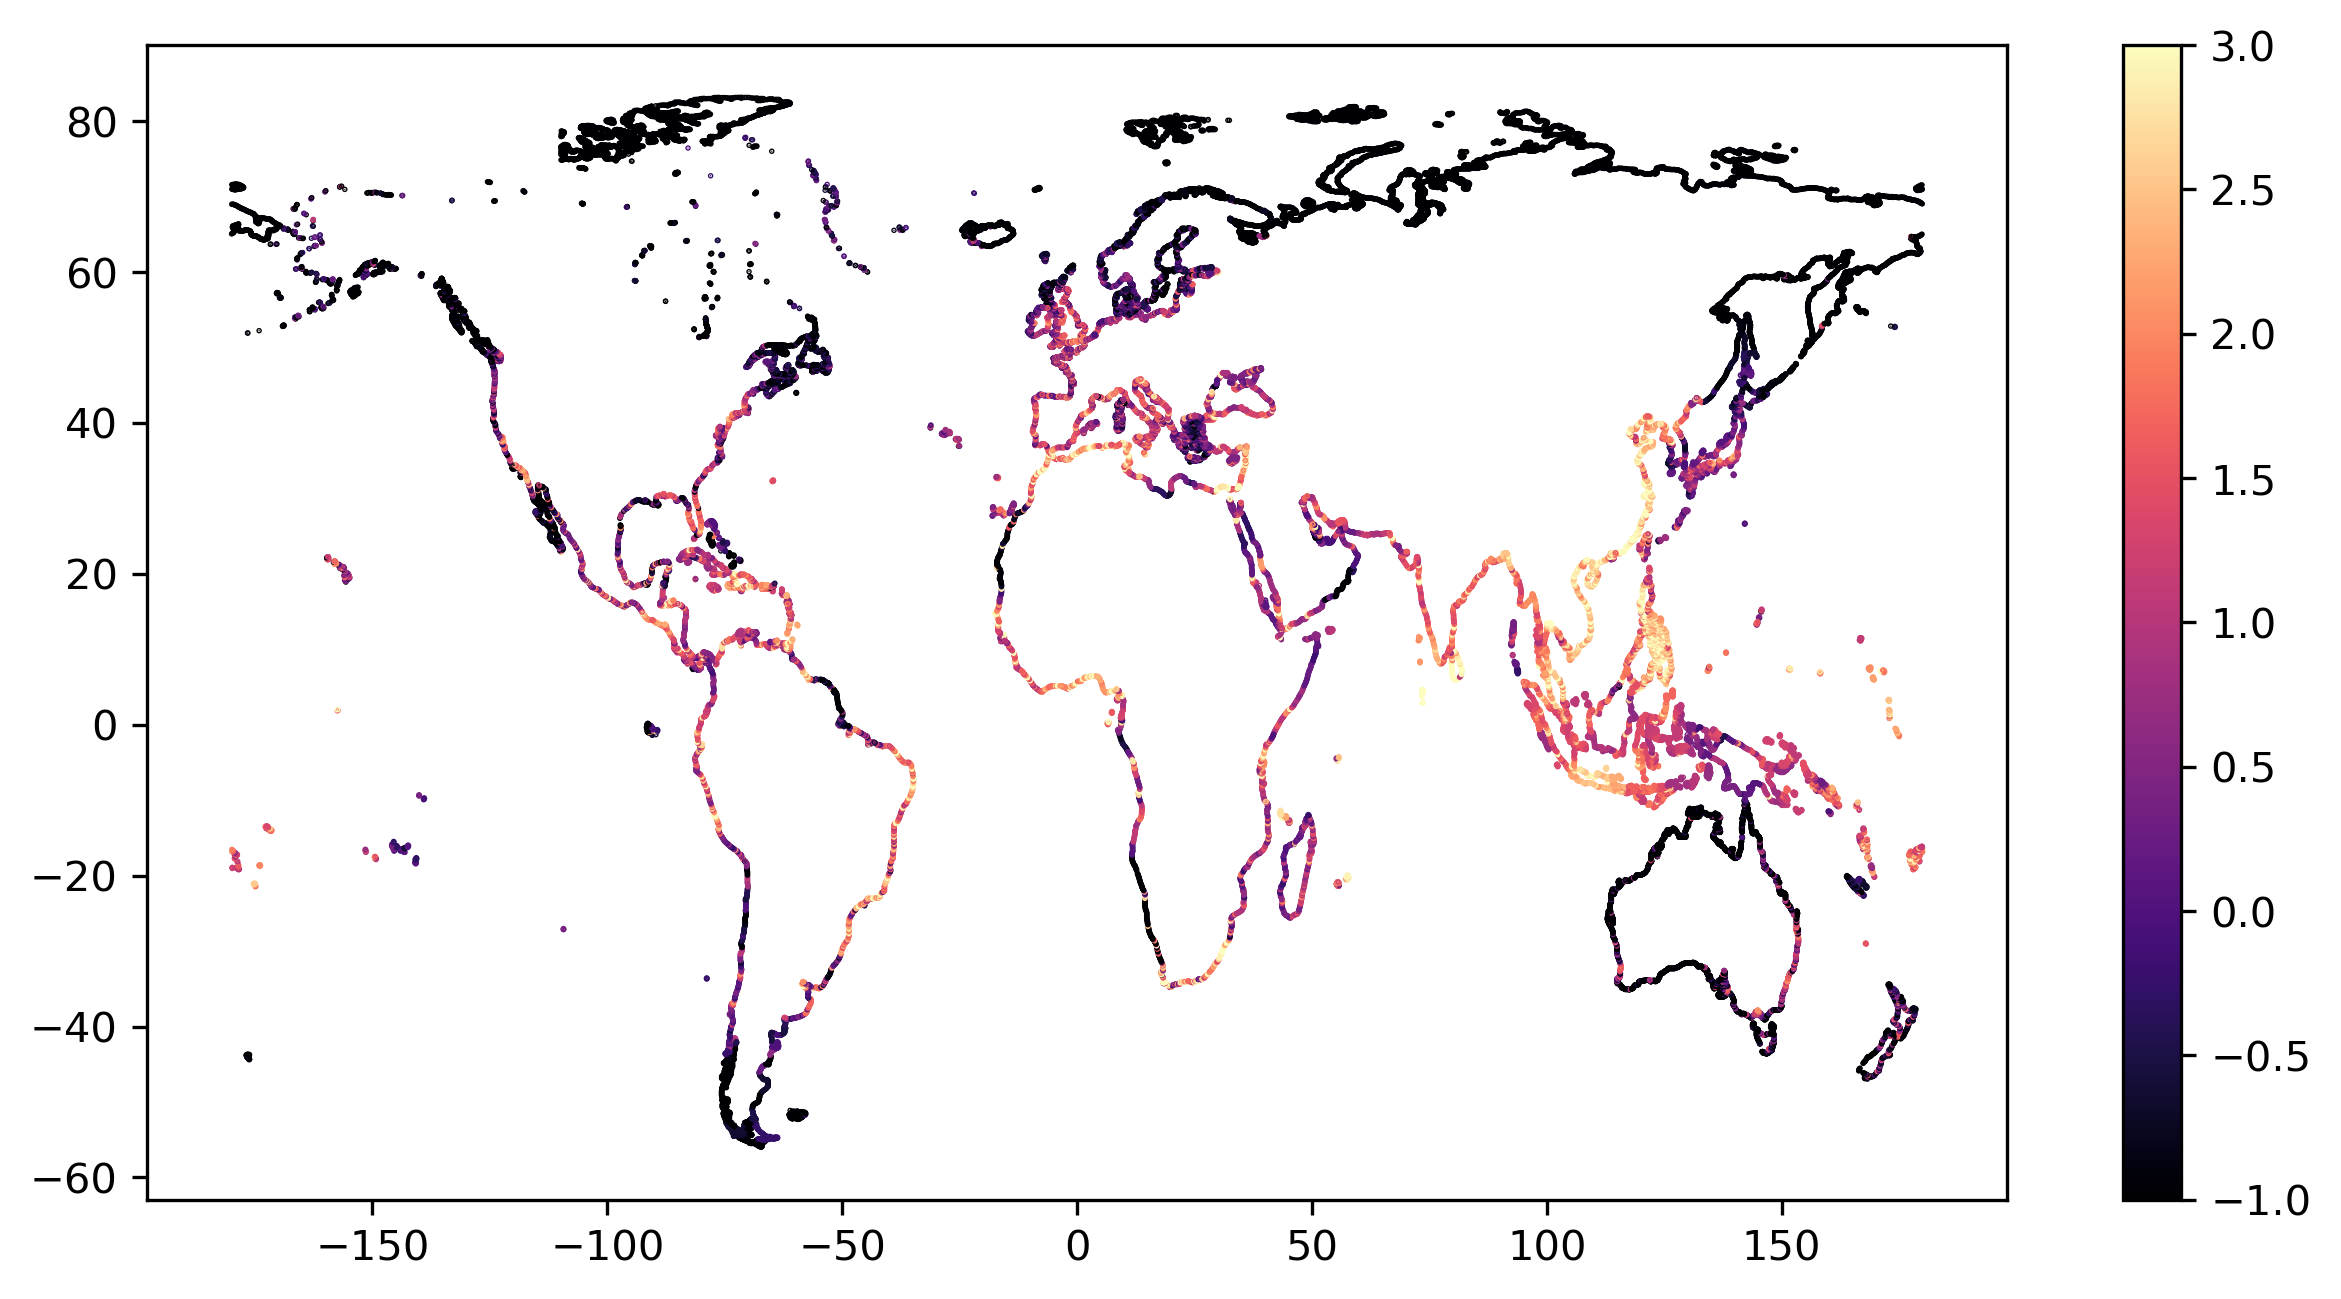

In [32]:
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(coastal_density_mpw_df['Longitude'], coastal_density_mpw_df['Latitude'], c=np.log10(np.array(coastal_density_mpw_df['MPW_Cell'], dtype=np.float32)), cmap=plt.cm.magma, s=0.1, vmin=-1, vmax=3)
plt.colorbar()
plt.show()

array([11.134374588771157, 11.134374588771157, 11.134374588771157, ...,
       16.720193746258598, 0.0, 0.0], dtype=object)